In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import time
from tqdm import tqdm 
from itertools import product
import scipy as sp
from mpl_toolkits.mplot3d import Axes3D
import multiprocessing
import concurrent.futures

%matplotlib inline

In [2]:
c = 299792458 # m/s
e = 1.602176634e-19 # C 
muon_mass = 105.6583755e6*e / (c**2) # kg
electron_mass = 0.51099895000*e/(c**2) # kg

## Loading data

In [3]:
raw_data = pd.read_csv("./data/dataset.txt",sep=" ",index_col=False)
raw_data=raw_data[raw_data["pz_positron"]>0].reset_index(drop=True)
number_events = raw_data["x_scattering"].shape[0]
raw_data

,x_scattering,y_scattering,z_scattering,px_mu1,py_mu1,pz_mu1,px_mu2,py_mu2,pz_mu2,px_positron,py_positron,pz_positron
0,0.006700,-0.000174,0.013579,0.026168,0.005782,27.3669,-0.026168,-0.005782,20.2281,0,0,47.5950
1,-0.001808,0.005898,0.000123,0.029397,-0.004837,19.3068,-0.029397,0.004837,30.3273,0,0,49.6341
2,0.001924,-0.004531,0.010167,0.001136,-0.023830,28.3075,-0.001136,0.023830,19.3267,0,0,47.6342
3,0.007570,0.004268,0.008222,-0.002160,-0.011196,17.4952,0.002160,0.011196,30.0357,0,0,47.5309
4,0.004862,-0.005216,0.011934,0.031203,0.005236,21.6927,-0.031203,-0.005236,26.3991,0,0,48.0918
...,...,...,...,...,...,...,...,...,...,...,...,...
999909,-0.002064,-0.006667,0.024110,0.013418,0.010555,26.1718,-0.013418,-0.010555,19.6198,0,0,45.7916
999910,-0.001824,-0.001494,0.026105,0.003372,0.019434,25.1396,-0.003372,-0.019434,20.5562,0,0,45.6958
999911,0.002128,-0.000650,0.028801,0.009716,0.008148,21.7877,-0.009716,-0.008148,22.5688,0,0,44.3564
999912,-0.000129,-0.003546,0.014003,-0.017934,0.020388,19.8603,0.017934,-0.020388,28.1794,0,0,48.0397


In [4]:
# here we rename all the columns to use an easy notation x y z
R_scattering = raw_data[['x_scattering', 'y_scattering', 'z_scattering']].rename(columns={'x_scattering': 'x', 'y_scattering': 'y', 'z_scattering': 'z'})
P_e = raw_data[['px_positron', 'py_positron', 'pz_positron']].rename(columns={'px_positron': 'x', 'py_positron': 'y', 'pz_positron': 'z'})
P_mu = raw_data[['px_mu1', 'py_mu1', 'pz_mu1']].rename(columns={'px_mu1': 'x', 'py_mu1': 'y', 'pz_mu1': 'z'})
P_anti_mu = raw_data[['px_mu2', 'py_mu2', 'pz_mu2']].rename(columns={'px_mu2': 'x', 'py_mu2': 'y', 'pz_mu2': 'z'})

# Detectors for positrons and muons

### Helper functions for this section

In [5]:
def get_velocity(p,m):
    vx = p["x"]*1e9*e/(c*m)
    vy = p["y"]*1e9*e/(c*m)
    vz = p["z"]*1e9*e/(c*m)
    v=pd.DataFrame({"x":vx,"y":vy,"z":vz})

    return v

In [6]:
def propagate_particles(r_old, p, z_new, m):
    # find proper time
    v=get_velocity(p,m)
    t=(z_new-r_old["z"])/v["z"]

    # compute new positions
    x_new = r_old["x"] + v["x"]*t
    y_new = r_old["y"] + v["y"]*t
    z_new = r_old["z"] + v["z"]*t
    
    r_new = pd.DataFrame({"x":x_new,"y":y_new,"z":z_new})
    return r_new

In [7]:
def get_edges(pixel_length, x_center, y_center, x_length, y_length, oversize_pixels = 20):

    edges_x = np.arange(x_center-x_length/2 -oversize_pixels * pixel_length, x_center + x_length/2 + oversize_pixels * pixel_length ,pixel_length)
    edges_y = np.arange(y_center-y_length/2 -oversize_pixels * pixel_length, y_center + y_length/2 + oversize_pixels * pixel_length ,pixel_length)

    return [edges_x, edges_y]

In [8]:
class Detector:
    
    def __init__(self, x_center, y_center, z_center, x_length, y_length, pixel_length):
        self.x_center = x_center
        self.y_center = y_center
        self.z_center = z_center
        self.x_length = x_length
        self.y_length = y_length
        self.pixel_length = pixel_length
        self.dataset_dict = {}

        # create an array with all pixel_centers
        self.npixels_x = int(x_length / pixel_length)
        self.npixels_y = int(y_length / pixel_length)
        x_range = np.linspace(x_center - x_length/2 + pixel_length/2, x_center + x_length/2 - pixel_length/2, self.npixels_x)
        y_range = np.linspace(y_center - y_length/2 + pixel_length/2, y_center + y_length/2 - pixel_length/2, self.npixels_y)
        x, y = np.meshgrid(x_range, y_range)
        self.pixel_centers = np.column_stack((x.flatten(), y.flatten(), self.z_center*np.ones(len(x_range)*len(y_range) )))

        # control values
        self.is_noise_generated = False
        self.n_events = 0

    def load_data(self,R_positions: pd.DataFrame, label = "none"):
        #check if the label is already there

        if label in self.dataset_dict.keys():
            print("ERROR: trying to add a dataset with a label already in used --> stop")
            exit()

        if self.n_events == 0:
            self.n_events = R_positions.shape[0]
        else:
            if R_positions.shape[0]!=self.n_events:
                print("ERROR: trying to add a datased with a different number of events with respect to the previous one --> stop")
        
        hits_map = R_positions.copy()
        # center on 0,0 so we can get properly the pixel with respect to the detector center
        hits_map["x"] = hits_map["x"] - self.x_center 
        hits_map["y"] = hits_map["y"] - self.y_center

        # find the pixel center
        hits_map["x"] = np.trunc(hits_map["x"] / pixel_length ) * pixel_length + np.sign(hits_map["x"]) * pixel_length / 2
        hits_map["y"] = np.trunc(hits_map["y"] / pixel_length ) * pixel_length + np.sign(hits_map["y"]) * pixel_length / 2

        # put everything back in the correct place 
        hits_map["x"] = hits_map["x"] + self.x_center
        hits_map["y"] = hits_map["y"] + self.y_center        
        self.dataset_dict[label]=hits_map
        
    def get_positions(self,label = "none"):

        if label not in self.dataset_dict.keys():
            print("ERROR: trying to get the positions of a dataset with label {}, but it is not there --> stop".format(label))
        
        return self.dataset_dict[label]

    def generate_poisson_noise(self,lambda_param):
        if self.n_events == 0:
            print("ERROR: trying to create noise but no dataset loaded -->stop")
            exit()
        self.is_noise_generated = True
        
        n_noise_per_trigger = np.random.poisson(lambda_param, size=self.n_events)    
        random_indices = np.random.choice(self.pixel_centers.shape[0], size=np.sum(n_noise_per_trigger))
        
        self.noise_list = np.split(self.pixel_centers[random_indices], np.cumsum(n_noise_per_trigger)[:-1])

    def get_noise_events(self, trigger_number):
        if not self.is_noise_generated:
            print("ERROR: trying to get a noise event, but noise is not generated yet! --> stop")
            exit()
        list_events = self.noise_list[trigger_number]
        if len(list_events) != 0:
            #list_events = np.vstack(list_events)
            return np.unique(list_events, axis=0)
        return np.array(list_events)
    
    def get_real_events(self, trigger_number, label = "all"):
        # if we need the event from a specific dataset
        if label != "all":
            return self.dataset_dict[label].loc[trigger_number].values

        # if we need all events then:
        # if there are the same pixels more than one time remove the duplicates
        list_events = [data.loc[trigger_number].values for data in self.dataset_dict.values()]
        list_events = np.vstack(list_events)
        unique_pixels = np.unique(list_events, axis=0)
        return unique_pixels

    def get_trigger(self, trigger_number):
        real_list = self.get_real_events(trigger_number)
        noise_list = self.get_noise_events(trigger_number)
        all_events = np.vstack([real_list,noise_list])
        unique_events = np.unique(all_events, axis=0)
        return unique_events

            
        

In [9]:
def choose_detector_specs(r, tolerance, pixel_length, verbose = True):
    # find max and min and center
    x_min, x_max = r["x"].min()*tolerance, r["x"].max()*tolerance
    y_min, y_max = r["y"].min()*tolerance, r["y"].max()*tolerance
    x_center = round((x_max + x_min )/2, 4)
    y_center = round((y_max + y_min )/2, 4)

    #find proper detector dimention taking into account the size of each single pixel
    half_x = (x_max-x_min)*tolerance / 2
    half_x = int(half_x / pixel_length) * pixel_length # now this value is a multiple of pixel_length
    length_detector_x = 2*half_x
    n_pixels_x = length_detector_x/pixel_length

    half_y = (y_max-y_min)*tolerance / 2
    half_y = int(half_y / pixel_length) * pixel_length
    length_detector_y = 2*half_y
    n_pixels_y = length_detector_y/pixel_length

    #brief summary
    if verbose:
        print("\nfor detector at z={} m we choose:\n".format(round(r["z"][0], 3)),
              "- length".format(r["z"][0]), "of {} m along x and {} m along y\n".format(round(length_detector_x,6), round(length_detector_y,6)),
              "- center in ({}, {}) m \n".format(x_center,y_center),
              "- with square pixels of size {}x{} μm the detector is a matrix of {}x{} pixels".format(pixel_length*1e6,pixel_length*1e6, round(n_pixels_x), round(n_pixels_y)))
        
    return x_center, y_center, r["z"][0], length_detector_x, length_detector_y, pixel_length
    return 

In [10]:
def place_detector_on_hitsmap(ax, x_center, y_center, length_detector_x, length_detector_y):
    x_min = x_center - length_detector_x/2
    y_min = y_center - length_detector_y/2
    square = Rectangle((x_min, y_min), length_detector_x, length_detector_y, linewidth=1.5, edgecolor='red', facecolor='none',label="detector")
    _ = ax.add_patch(square)
    ax.legend(loc='upper right')
 
    return

## Analysis for positrons

### Code

In [11]:
z_positron_detectors = np.array([-0.30, -0.15]) # z of the silicon trackers before berillium target (we're traking positrons here)

r_upstream_positions = {}
positron_detectors= {}
for z_new in z_positron_detectors:
    r_upstream_positions[z_new]=R_scattering.copy()
    r_upstream_positions[z_new]["z"]=np.ones(number_events)*z_new

Assuming square pixels of size 200.0x200.0 μm and a tolerance of 1.05 %

for detector at z=-0.3 m we choose:
 - length of 0.022 m along x and 0.022 m along y
 - center in (-0.0, 0.0) m 
 - with square pixels of size 200.0x200.0 μm the detector is a matrix of 110x110 pixels

for detector at z=-0.15 m we choose:
 - length of 0.022 m along x and 0.022 m along y
 - center in (-0.0, 0.0) m 
 - with square pixels of size 200.0x200.0 μm the detector is a matrix of 110x110 pixels


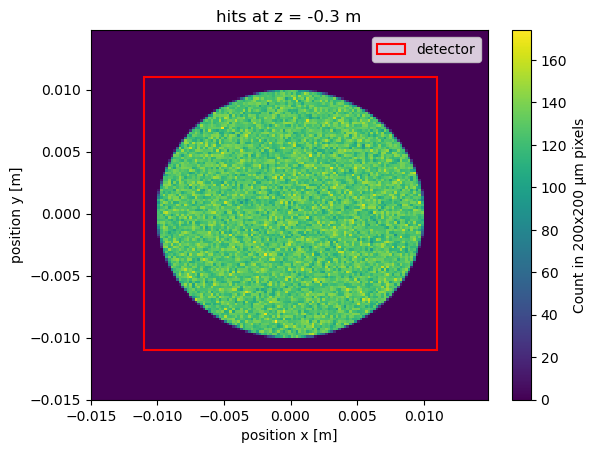

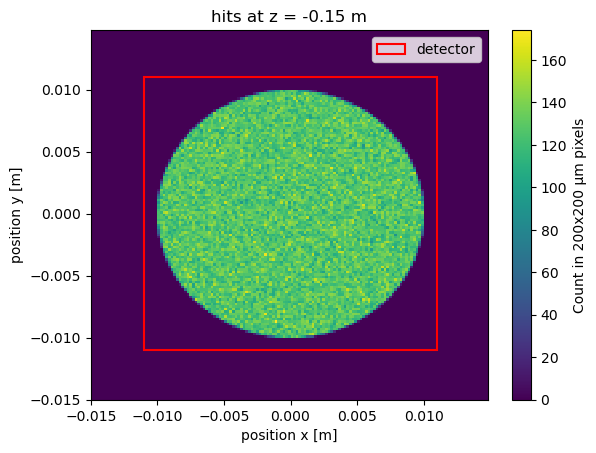

In [12]:
pixel_length = 200e-6 #m
tolerance = 1.05 #%
print("Assuming square pixels of size {}x{} μm and a tolerance of {} %".format(pixel_length*1e6,pixel_length*1e6, tolerance))
for z_pos, data in  r_upstream_positions.items():
    # create hits map 
    x_center, y_center, z_center, x_length, y_length, pixel_length = choose_detector_specs(data,tolerance,pixel_length)
    detector = Detector(x_center, y_center,z_center,x_length, y_length, pixel_length)
    detector.load_data(data)
    positron_detectors[z_pos]=detector

    #plot hits_map
    df_positions = detector.get_positions()
    fig, ax = plt.subplots(1,1)
    hist = ax.hist2d(df_positions["x"],df_positions["y"],bins=get_edges(pixel_length, x_center, y_center, x_length, y_length), cmap = "viridis")
    cbar = fig.colorbar(hist[3], ax=ax, cmap="viridis")
    pixel_length_label = round(pixel_length*1e6)
    cbar.set_label('Count in {}x{} μm pixels'.format(pixel_length_label,pixel_length_label))
    ax.set_xlabel("position x [m]")
    ax.set_ylabel("position y [m]")
    ax.set_title("hits at z = {} m".format(data["z"][0]))
    place_detector_on_hitsmap(ax, x_center, y_center, x_length, y_length)

### Comments on positrons

## Analysis for muons before magnetic field

### Code

In [13]:
z_downstream_muons_detectors = np.array([2, 6, 8])

r_downstream__muons_positions = {}
upstream_muons_detectors = {}
for z_new in z_downstream_muons_detectors:
    R_mu_tmp = propagate_particles(R_scattering,P_mu,z_new,muon_mass)
    R_anti_mu_tmp = propagate_particles(R_scattering,P_anti_mu,z_new,muon_mass)
    data_tmp = {"n": R_mu_tmp.copy(), "p": R_anti_mu_tmp.copy()}
    r_downstream__muons_positions[z_new]=data_tmp

Assuming square pixels of size 50.0x50.0 μm and a tolerance of 1.05 %:

for detector at z=2.0 m we choose:
 - length of 0.029 m along x and 0.0291 m along y
 - center in (-0.0, -0.0) m 
 - with square pixels of size 50.0x50.0 μm the detector is a matrix of 580x582 pixels
 ATTENTION: in this case only 0.0043% of the pairs are at a distance smaller than the pixel size

for detector at z=6.0 m we choose:
 - length of 0.0432 m along x and 0.0438 m along y
 - center in (0.0001, -0.0) m 
 - with square pixels of size 50.0x50.0 μm the detector is a matrix of 864x876 pixels
 ATTENTION: in this case only 0.0012% of the pairs are at a distance smaller than the pixel size

for detector at z=8.0 m we choose:
 - length of 0.0505 m along x and 0.0513 m along y
 - center in (0.0002, 0.0) m 
 - with square pixels of size 50.0x50.0 μm the detector is a matrix of 1010x1026 pixels
 ATTENTION: in this case only 0.0007% of the pairs are at a distance smaller than the pixel size


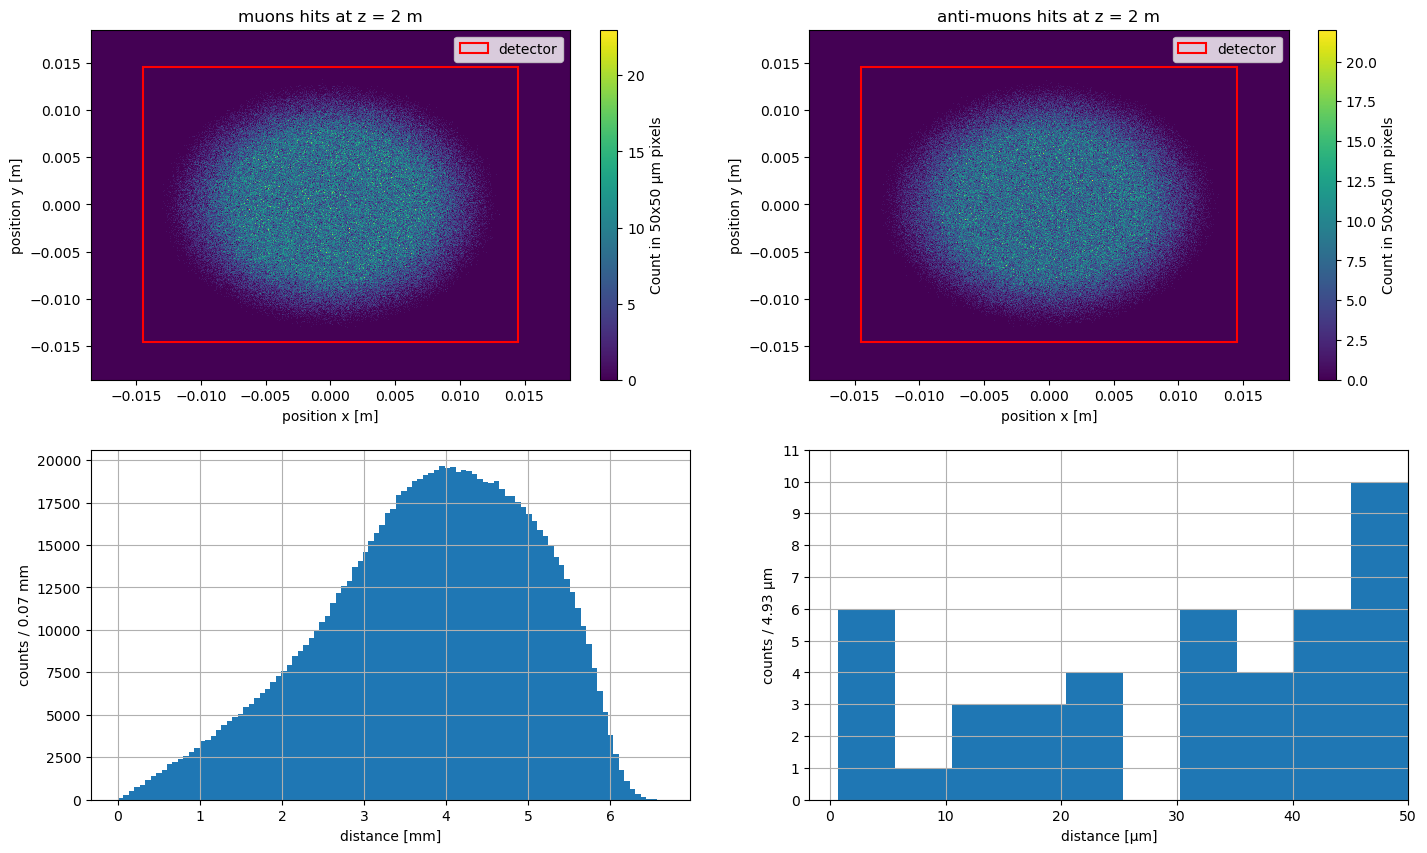

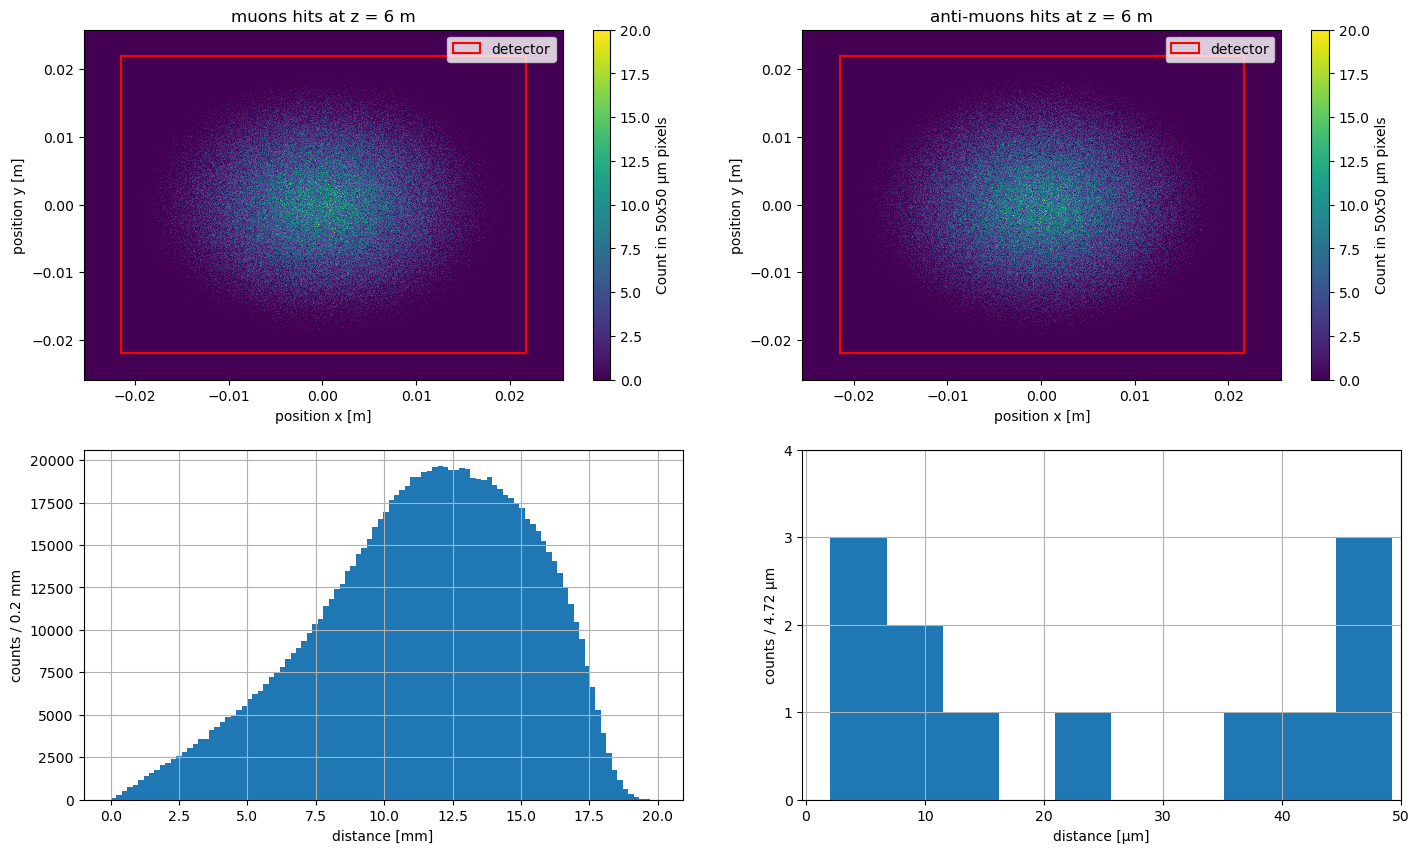

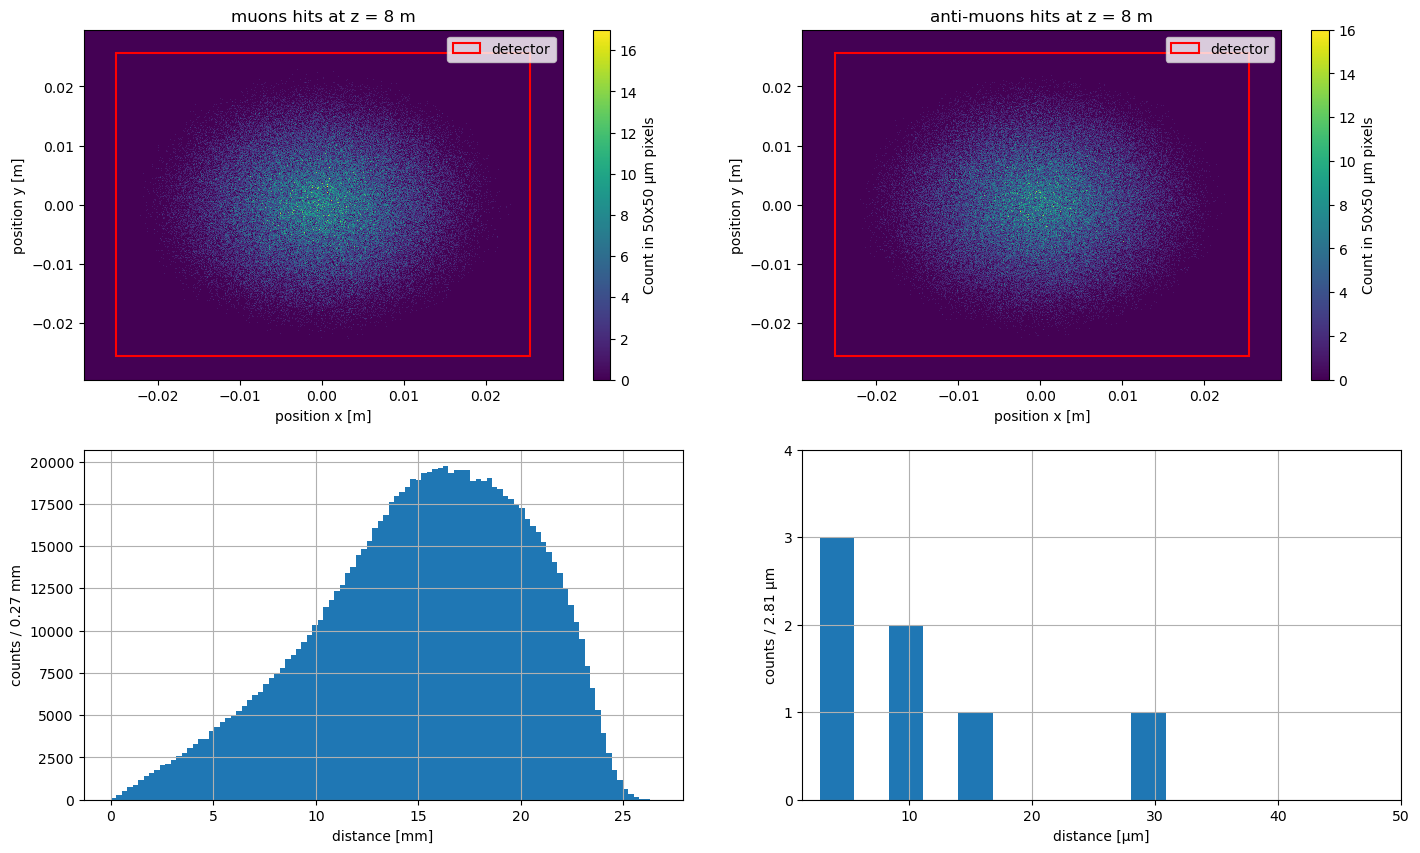

In [14]:
pixel_length = 50e-6 #m
tolerance = 1.05 #%
print("Assuming square pixels of size {}x{} μm and a tolerance of {} %:".format(pixel_length*1e6,pixel_length*1e6, tolerance))

for z_new, data_dic in  r_downstream__muons_positions.items():
    # create hits map
    total_dataset = pd.concat(data_dic.values(),ignore_index=True)
    x_center, y_center, z_center, x_length, y_length, pixel_length = choose_detector_specs(total_dataset,tolerance,pixel_length)
    edges = get_edges(pixel_length, x_center, y_center, x_length, y_length, 80)

    detector_tmp = Detector(x_center, y_center, z_center, x_length, y_length, pixel_length)
    detector_tmp.load_data(data_dic["p"],"p")
    detector_tmp.load_data(data_dic["n"],"n")

    upstream_muons_detectors[z_new]=detector_tmp

    #plot hits maps
    df_positions_p = detector_tmp.get_positions("p")
    df_positions_n = detector_tmp.get_positions("n")
    fig, ax = plt.subplots(2,2, figsize = (17,10) )
    hist_muons_p = ax[0,0].hist2d(df_positions_p["x"],df_positions_p["y"],bins=edges, cmap = "viridis")
    hist_muons_n = ax[0,1].hist2d(df_positions_n["x"],df_positions_n["y"],bins=edges, cmap = "viridis")
 
    histograms_2d = [hist_muons_n, hist_muons_p]
    labels = ["muons", "anti-muons"]

    for a, hist, label in zip(ax[0],histograms_2d, labels):
        cbar = fig.colorbar(hist[3], ax=a, cmap="viridis")
        pixel_length_label = round(pixel_length*1e6)
        cbar.set_label('Count in {}x{} μm pixels'.format(pixel_length_label,pixel_length_label))
        a.set_xlabel("position x [m]")
        a.set_ylabel("position y [m]")
        a.set_title("{} hits at z = {} m".format(label, z_new))
        place_detector_on_hitsmap(a, x_center, y_center, x_length, y_length)

    
    #plot 1d histogram with separation between pairs distribution
    df_dist = (data_dic["p"]-data_dic["n"])
    abs_dist = np.sqrt(df_dist["x"]**2 + df_dist["y"]**2 ) # distance in m
    abs_dist_small = abs_dist[abs_dist < pixel_length]     # select events with distance between muons < pixel_length

    abs_dist=abs_dist*1e3                # conversion from m --> mm to make the graph easier to read
    abs_dist_small=abs_dist_small*1e6    # conversion from m --> μm to make the graph easier to read
    
    hist_dist = ax[1,0].hist(abs_dist,bins=100)
    hist_dist_lost = ax[1,1].hist(abs_dist_small,bins=10)
    ax[1,1].set_xlim(right = pixel_length*1e6)
    ax[1,1].set_yticks(range( int(hist_dist_lost[0].max())+2))

    ax[1,0].set_xlabel("distance [mm]")
    ax[1,1].set_xlabel("distance [μm]")
    
    ax[1,0].grid(True)
    ax[1,1].grid(True)

    ax[1,0].set_ylabel("counts / {} mm".format(round(hist_dist[1][1]-hist_dist[1][0],2)))
    ax[1,1].set_ylabel("counts / {} μm".format(round(hist_dist_lost[1][1]-hist_dist_lost[1][0],2)))

    fraction_pair_lost = round(np.sum(hist_dist_lost[0])*100/np.sum(hist_dist[0]),6)
    print(" ATTENTION: in this case only {}% of the pairs are at a distance smaller than the pixel size".format(fraction_pair_lost))    
    

In [15]:
df_1 = upstream_muons_detectors[2].get_positions("p")
df_2 = upstream_muons_detectors[8].get_positions("p")
diff = df_2["y"]-df_1["y"]
diff_bool = np.sum(abs(diff) < pixel_length)/diff.shape[0]
print(diff_bool)

0.007582652108081295


## Propagation of the muons and antimuons in the magnetic field

### Helper functions for this subsection


In [16]:
def propagate_muons_in_Bfield(R_entrance, p_entrance, z_exit, m, B):
    p_perp = np.sqrt(p_entrance["x"]**2 + p_entrance["z"]**2) # S. I. units
    R = p_perp*1e9/(c*B)
    x_centre = R_entrance["x"] + R*p_entrance["z"]/p_perp
    z_centre = R_entrance["z"] - R*p_entrance["x"]/p_perp

    z_new = np.ones(len(R))*z_exit
    x_new = x_centre - np.sqrt(R**2 - (z_new-z_centre)**2)

    chord = np.sqrt( (z_new-R_entrance["z"])**2 + (x_new-R_entrance["x"])**2 )
    theta = np.sin(chord/(2*R))
    arc = theta*R
    y_new = R_entrance["y"] + arc*p_entrance["y"]/p_perp
    r_new = pd.DataFrame({"x": x_new, "y": y_new, "z": z_new})
    
    return r_new, theta


def propagate_antimuons_in_Bfield(R_entrance, p_entrance, z_exit, m, B):
    p_perp = np.sqrt(p_entrance["x"]**2 + p_entrance["z"]**2) # S. I. units
    R = p_perp*1e9/(c*B)
    x_centre = R_entrance["x"] - R*p_entrance["z"]/p_perp  # different sign here for antimuons
    z_centre = R_entrance["z"] + R*p_entrance["x"]/p_perp

    z_new = np.ones(len(R))*z_exit
    x_new = x_centre + np.sqrt(R**2 - (z_new-z_centre)**2)

    chord = np.sqrt( (z_new-R_entrance["z"])**2 + (x_new-R_entrance["x"])**2 )
    theta = np.arcsin(chord/(2*R))
    arc = theta*R
    y_new = R_entrance["y"] + arc*p_entrance["y"]/p_perp
    r_new = pd.DataFrame({"x": x_new, "y": y_new, "z": z_new})
    
    return r_new, theta


def propagate_mu_momenta(p_entrance, rot_angle):
    px_new = p_entrance["z"]*np.sin(rot_angle)+p_entrance["x"]*np.cos(rot_angle)
    py_new = p_entrance["y"]
    pz_new = p_entrance["z"]*np.cos(rot_angle)-p_entrance["x"]*np.sin(rot_angle)
    p_new = pd.DataFrame({"x": px_new, "y": py_new, "z": pz_new})
    
    return p_new


def propagate_antimu_momenta(p_entrance, rot_angle):
    px_new = -p_entrance["z"]*np.sin(rot_angle)+p_entrance["x"]*np.cos(rot_angle)
    py_new = p_entrance["y"]
    pz_new = p_entrance["z"]*np.cos(rot_angle)+p_entrance["x"]*np.sin(rot_angle)
    p_new = pd.DataFrame({"x": px_new, "y": py_new, "z": pz_new})
    
    return p_new

### Code

In [17]:
B = 1.7 # T
L = 2 # m
z_mag = 8 # m

In [18]:
R_mu_entrance = propagate_particles(R_scattering, P_mu, z_mag, muon_mass)
R_anti_mu_entrance = propagate_particles(R_scattering, P_anti_mu, z_mag, muon_mass)

#### Quick check

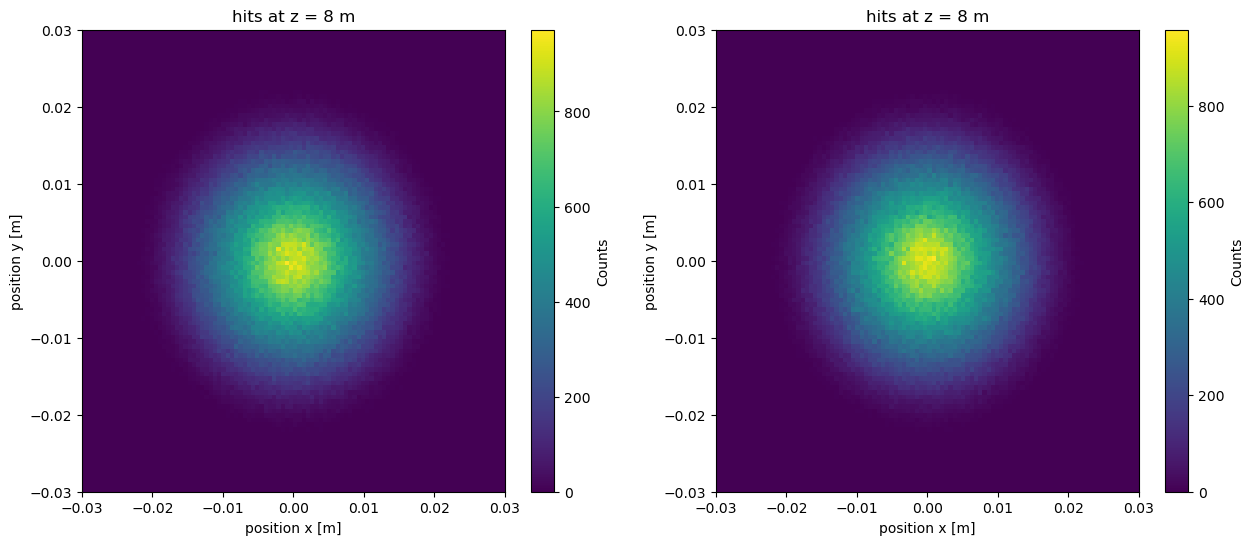

In [19]:
# this part is just to have a quick visual idea of the position of the μ at the beginning of the B field region
# it can be deleted later
fig, ax = plt.subplots(1, 2, figsize=(15,6))
hist0 = ax[0].hist2d(R_mu_entrance["x"], R_mu_entrance["y"], bins=(100,100), range=[[-0.03,0.03],[-0.03,0.03]], cmap = "viridis")
colorbar = fig.colorbar(hist0[3], ax=ax[0], cmap="viridis")
colorbar.set_label('Counts')
ax[0].set_xlabel("position x [m]")
ax[0].set_ylabel("position y [m]")
ax[0].set_title("hits at z = {} m".format(z_mag))

hist1 = ax[1].hist2d(R_anti_mu_entrance["x"], R_anti_mu_entrance["y"], bins=(100,100), range=[[-0.03,0.03],[-0.03,0.03]], cmap = "viridis")
colorbar = fig.colorbar(hist1[3], ax=ax[1], cmap="viridis")
colorbar.set_label('Counts')
ax[1].set_xlabel("position x [m]")
ax[1].set_ylabel("position y [m]")
ax[1].set_title("hits at z = {} m".format(z_mag))
plt.show()

### Code

In [20]:
# propagation of the muons and antimuons in the magnetic field
z_exit = L+z_mag # m
R_mu_exitB, theta_mu = propagate_muons_in_Bfield(R_mu_entrance, P_mu, z_exit, muon_mass, B)
R_anti_mu_exitB, theta_antimu = propagate_antimuons_in_Bfield(R_anti_mu_entrance, P_anti_mu, z_exit, muon_mass, B)

#### Quick check

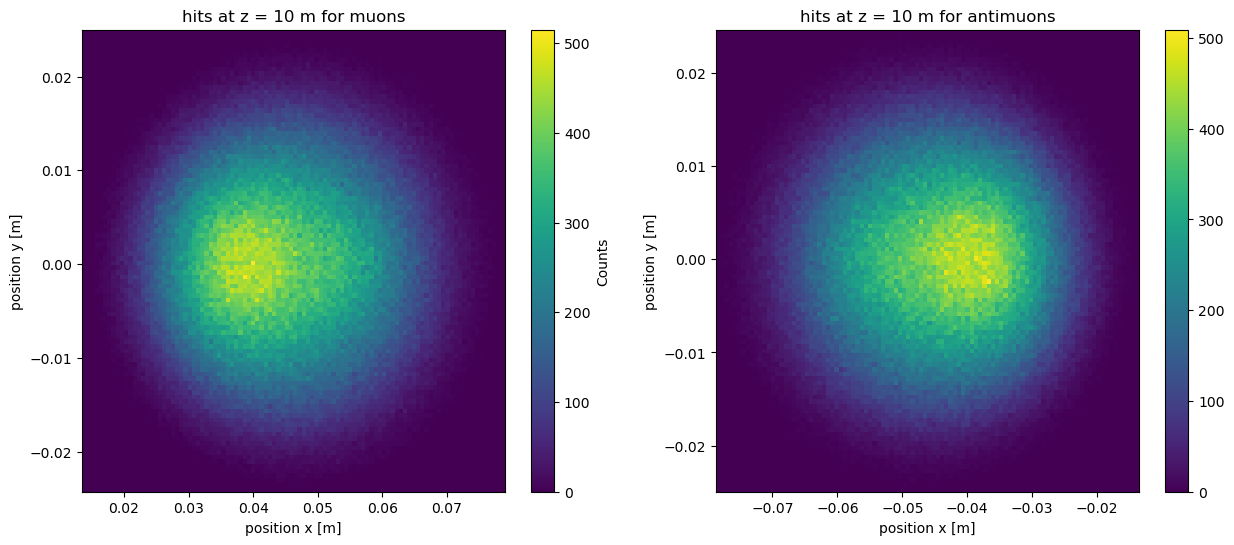

In [21]:
# plot to check the muons location at the exit of the magnetic field
# it can be deleted later
fig, ax = plt.subplots(1, 2, figsize=(15,6))
hist0 = ax[0].hist2d(R_mu_exitB["x"], R_mu_exitB["y"], bins=(100,100), cmap = "viridis")
colorbar = fig.colorbar(hist0[3], ax=ax[0], cmap="viridis")
colorbar.set_label('Counts')
ax[0].set_xlabel("position x [m]")
ax[0].set_ylabel("position y [m]")
ax[0].set_title("hits at z = {} m for muons".format(z_exit))

hist1 = ax[1].hist2d(R_anti_mu_exitB["x"], R_anti_mu_exitB["y"], bins=(100,100), cmap = "viridis")
cbar = fig.colorbar(hist1[3], ax=ax[1], cmap="viridis")
# cbar.set_label('Count in {}x{} μm pixels'.format(pixel_length_label,pixel_length_label))
ax[1].set_xlabel("position x [m]")
ax[1].set_ylabel("position y [m]")
ax[1].set_title("hits at z = {} m for antimuons".format(z_exit))

plt.show()

### Code

In [22]:
# propagation of the muons and antimuons momenta in the magnetic field
P_mu_afterB = propagate_mu_momenta(P_mu, theta_mu)
P_anti_mu_afterB = propagate_antimu_momenta(P_anti_mu, theta_antimu)

#### Quick check

In [23]:
# check for an arbitrary position 
z_exit = 13. # m

R_mu_tmp = propagate_particles(R_mu_exitB, P_mu_afterB, z_exit, muon_mass)
R_anti_mu_tmp = propagate_particles(R_anti_mu_exitB, P_anti_mu_afterB, z_exit, muon_mass)

Text(0, 0.5, 'position y [m]')

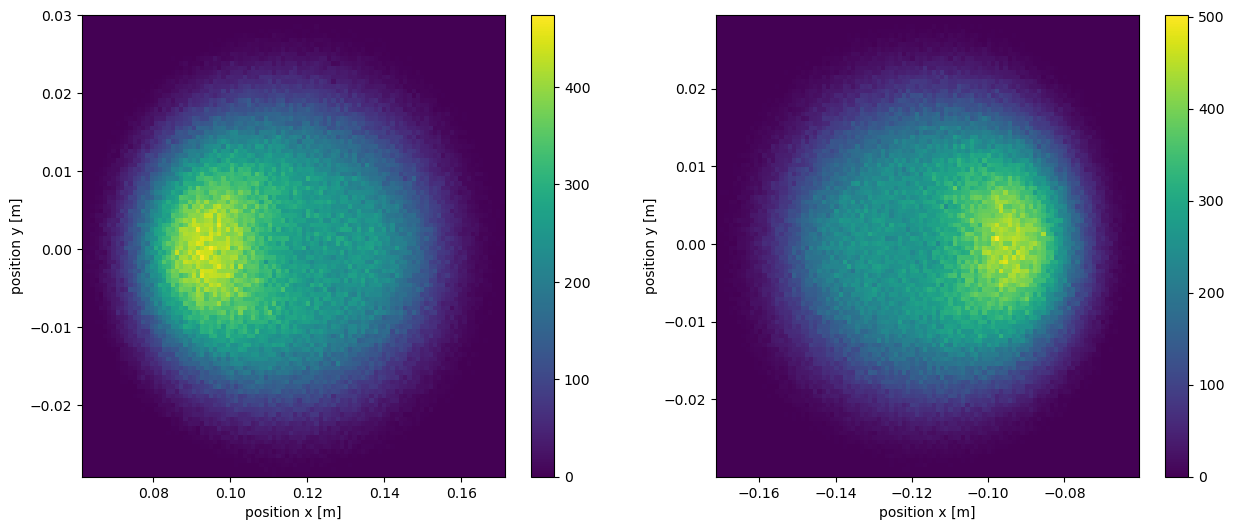

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
hist0 = ax[0].hist2d(R_mu_tmp["x"], R_mu_tmp["y"], bins=(100,100), cmap = "viridis")
cbar = fig.colorbar(hist0[3], ax=ax[0], cmap="viridis")
# cbar.set_label('Count in {}x{} μm pixels'.format(pixel_length_label,pixel_length_label))
ax[0].set_xlabel("position x [m]")
ax[0].set_ylabel("position y [m]")
# ax.set_title("hits at z = {} m".format(data["z"][0]))

hist1 = ax[1].hist2d(R_anti_mu_tmp["x"], R_anti_mu_tmp["y"], bins=(100,100), cmap = "viridis")
cbar = fig.colorbar(hist1[3], ax=ax[1], cmap="viridis")
# cbar.set_label('Count in {}x{} μm pixels'.format(pixel_length_label,pixel_length_label))
ax[1].set_xlabel("position x [m]")
ax[1].set_ylabel("position y [m]")

### Code

In [25]:
z_afterB_muons_detectors = np.array([12., 14., 16.]) # z of the silicon trackers after the magnetic field

r_afterB__muons_positions = {}
afterB_muons_detectors = {}
for z_new in z_afterB_muons_detectors:
    R_mu_tmp = propagate_particles(R_mu_exitB, P_mu_afterB, z_new, muon_mass)
    R_anti_mu_tmp = propagate_particles(R_anti_mu_exitB, P_anti_mu_afterB, z_new, muon_mass)
    data_tmp = {"mu": R_mu_tmp.copy(), "antimu": R_anti_mu_tmp.copy()}
    r_afterB__muons_positions[z_new] = data_tmp

Assuming square pixels of size 200.0x200.0 μm and a tolerance of 1.05 %:

for detector at z=12.0 m we choose:
 - length of 0.104 m along x and 0.0616 m along y
 - center in (0.0977, 0.0005) m 
 - with square pixels of size 200.0x200.0 μm the detector is a matrix of 520x308 pixels

for detector at z=12.0 m we choose:
 - length of 0.1044 m along x and 0.0616 m along y
 - center in (-0.0975, -0.0002) m 
 - with square pixels of size 200.0x200.0 μm the detector is a matrix of 522x308 pixels

for detector at z=14.0 m we choose:
 - length of 0.1376 m along x and 0.0688 m along y
 - center in (0.1467, 0.0005) m 
 - with square pixels of size 200.0x200.0 μm the detector is a matrix of 688x344 pixels

for detector at z=14.0 m we choose:
 - length of 0.1396 m along x and 0.0692 m along y
 - center in (-0.1459, -0.0003) m 
 - with square pixels of size 200.0x200.0 μm the detector is a matrix of 698x346 pixels

for detector at z=16.0 m we choose:
 - length of 0.1736 m along x and 0.076 m along y
 

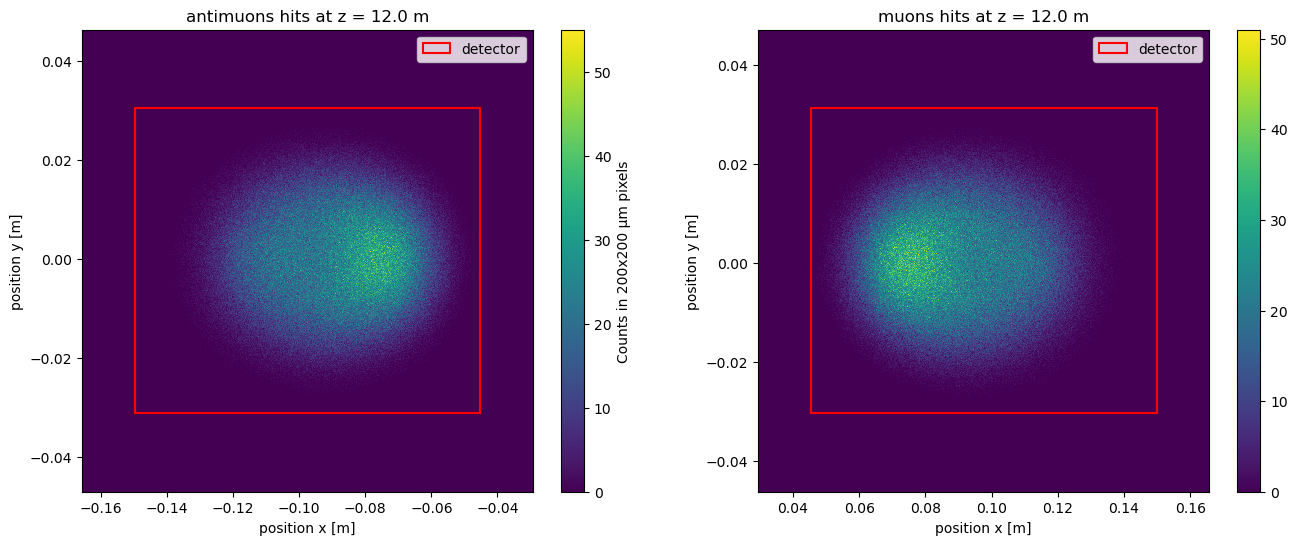

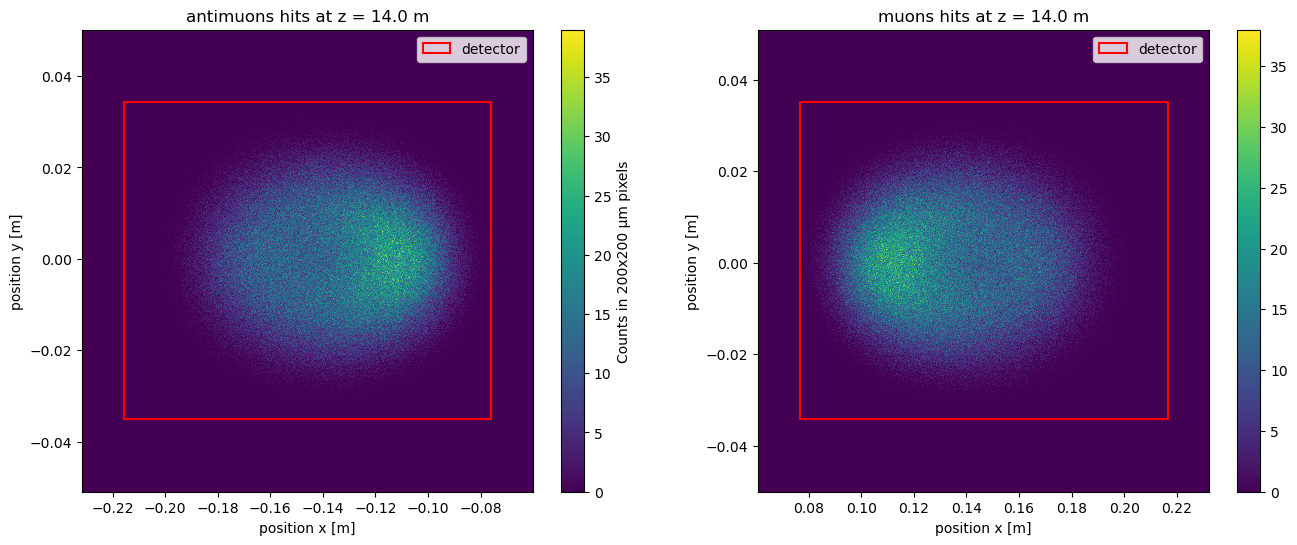

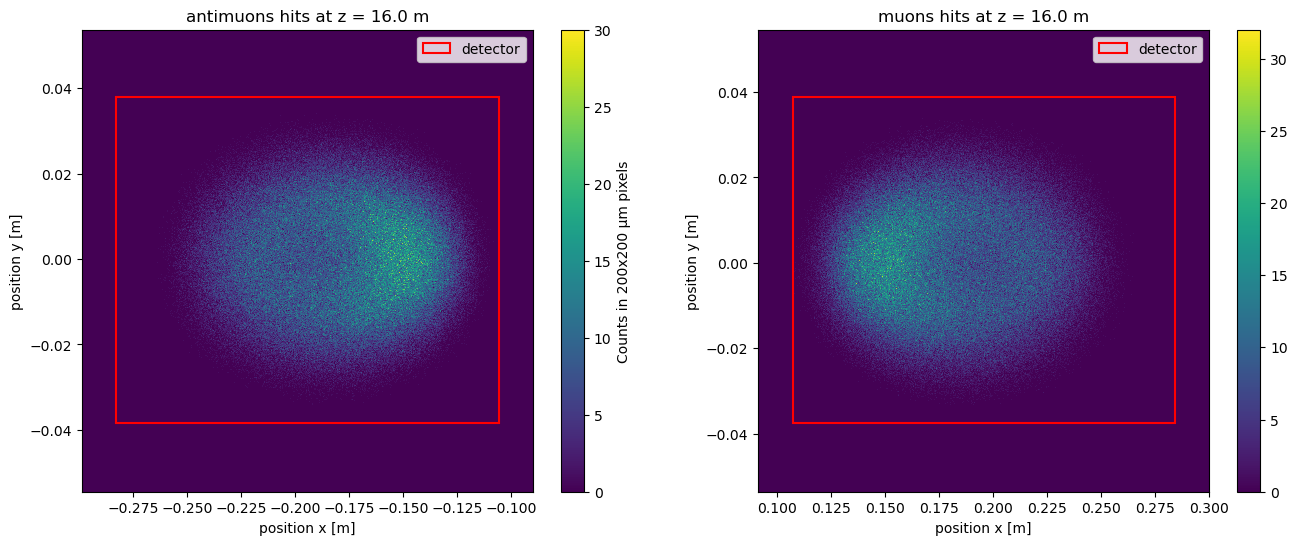

In [26]:
pixel_length = 200e-6 #m
tolerance = 1.05 #%
print("Assuming square pixels of size {}x{} μm and a tolerance of {} %:".format(pixel_length*1e6, pixel_length*1e6, tolerance))

for z_new, data in  r_afterB__muons_positions.items():
    # create hits map
    x_center_mu, y_center_mu, z_center_mu, x_length_mu, y_length_mu, pixel_length_mu = choose_detector_specs(data["mu"], tolerance, pixel_length)
    x_center_antimu, y_center_antimu, z_center_antimu, x_length_antimu, y_length_antimu, pixel_length_antimu = choose_detector_specs(data["antimu"], tolerance, pixel_length)

    x_length = max(x_length_mu, x_length_antimu)
    y_length = max(y_length_mu, y_length_antimu)
    
    edges_mu = get_edges(pixel_length_mu, x_center_mu, y_center_mu, x_length, y_length, 80)
    edges_antimu = get_edges(pixel_length_antimu, x_center_antimu, y_center_antimu, x_length, y_length, 80)

    detector_mu_tmp = Detector(x_center_mu, y_center_mu, z_center_mu, x_length, y_length, pixel_length)
    detector_mu_tmp.load_data(data["mu"])
    detector_antimu_tmp = Detector(x_center_antimu, y_center_antimu, z_center_antimu, x_length, y_length, pixel_length)
    detector_antimu_tmp.load_data(data["antimu"])
    
    detector_tmp = {
                    "mu": detector_mu_tmp,
                    "antimu": detector_antimu_tmp
                   }
    afterB_muons_detectors[z_new]=detector_tmp

    #plot hits maps
    df_positions_mu = detector_tmp["mu"].get_positions()
    df_positions_antimu = detector_tmp["antimu"].get_positions()
    fig, ax = plt.subplots(1, 2, figsize = (16, 6) )
    hist_muons = ax[1].hist2d(df_positions_mu["x"],df_positions_mu["y"], bins=edges_mu, cmap = "viridis")
    hist_antimuons = ax[0].hist2d(df_positions_antimu["x"], df_positions_antimu["y"], bins=edges_antimu, cmap = "viridis")

    colorbar = fig.colorbar(hist_muons[3], ax=ax[1], cmap="viridis")
    colorbar = fig.colorbar(hist_antimuons[3], ax=ax[0], cmap="viridis")
    pixel_length_label = round(pixel_length*1e6)
    colorbar.set_label('Counts in {}x{} μm pixels'.format(pixel_length_label, pixel_length_label))
    labels = ["antimuons", "muons"]
    for a, lab in zip(ax, labels):
        a.set_xlabel("position x [m]")
        a.set_ylabel("position y [m]")
        a.set_title("{} hits at z = {} m".format(lab, z_new))
    place_detector_on_hitsmap(ax[1], x_center_mu, y_center_mu, x_length, y_length)
    place_detector_on_hitsmap(ax[0], x_center_antimu, y_center_antimu, x_length, y_length)

## Noise generation

In [27]:
poisson_expected_value = 1
all_detectors = [positron_detectors, upstream_muons_detectors]

for detector_dict in all_detectors:
    for det in detector_dict.values():
        det.generate_poisson_noise(poisson_expected_value)

for position in  afterB_muons_detectors:
   for particle_det in afterB_muons_detectors[position].values():
       particle_det.generate_poisson_noise(poisson_expected_value)

## Traking

### helper functions

In [28]:
def get_possible_tracks(event_list, monotonic = True):
    triplets = np.array(list(product(*event_list)))
    # Seleziona le triplette con valori crescenti o decrescenti su x e y
    selected_triplets = []
    
    if not monotonic:
        return triplets
        
    for triplet in triplets:
        x_values = np.array([np.round(triplet[i][0],8) for i in range(len(event_list))])
        y_values = np.array([np.round(triplet[i][1],8) for i in range(len(event_list))])
        
        # Verifica se le x e y sono in ordine crescente o decrescente
        if np.all(np.diff(x_values) >= 0) or np.all(np.diff(x_values) <= 0):
            if np.all(np.diff(y_values) >= 0) or np.all(np.diff(y_values) <= 0):
                selected_triplets.append(np.array(triplet))
    return np.array(selected_triplets)

In [29]:
def get_pixel_lists(detector_dic, trigger_number):
    return [ det.get_trigger(trigger_number) for det in detector_dic.values()]

In [30]:
def get_straight_traces(traces):
    count = 0
    straight_trace =np.array([])
    for trace in traces:
        if (np.sum(trace[0][0] == trace[:,0]) == trace[:,0].shape[0]):
            if (np.sum(trace[0][1] == trace[:,1]) == trace[:,1].shape[0]):
                count = count + 1
                straight_trace = trace

    if count == 1:
        return straight_trace
    elif count > 1:
        print("more than one straight trace, positron lost")
        return
    elif count == 0:
        print("Positron not detected properly, no straight trace found")
        return

In [175]:
def fit_line_3d(matrix):
    # Estrai x, y, z dalla matrice
    matrix_t = matrix.T
    r0 = np.mean(matrix_t,axis=1)
    matrix_t_center = matrix_t - r0.reshape(3,1)

    cov = np.cov(matrix_t_center)
    result = sp.linalg.svd(cov)
    v0 = result[0][:,0]
    accuracy = result[1][0]/np.sum(result[1])
    

    return r0, v0, accuracy

In [212]:
def find_best_track(trace_list, n_traces = 1):
    fit_results = []
    fit_accuracies = []
    if len(trace_list.shape) == 2:
        trace_list = trace_list.reshape(1,trace_list.shape[0],trace_list.shape[1])
    for trace in trace_list:
        r0_tmp, v0_tmp, accuracy_tmp = fit_line_3d(trace)
        fit_results.append({"r0":r0_tmp, "v0":v0_tmp})
        fit_accuracies.append(accuracy_tmp)
    
    fit_accuracies = np.array(fit_accuracies)
    sorted_index = np.argsort(fit_accuracies)[::-1]
    if n_traces == 1:
        return [fit_results[sorted_index[0]]], [fit_accuracies[sorted_index[0]]], [trace_list[sorted_index[0]]]
    
    best_traces = trace_list[sorted_index[:n_traces]]
    best_fit_accuracies = fit_accuracies[sorted_index[:n_traces]]
    best_results = [fit_results[i] for i in sorted_index[:n_traces]]
    
    return best_results, best_fit_accuracies, best_traces 

In [213]:
def get_real_track(detector_list,trigger_number,label = "all"):
    real_pixels = np.array([det.get_real_events(trigger_number, label) for det in detector_list.values()])
    return real_pixels
    

In [214]:
def plot_3d_line_and_points(ro, v0, points):
    # ATTENTION: use %matplotlib ipympl when you use the function!
    # linspace parameter
    t = np.linspace(-10, 10, 100)

    # point to plot
    line_points = ro + np.outer(t, v0)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], label='Points')
    ax.plot(line_points[:, 0], line_points[:, 1], line_points[:, 2], label='Line', color='red')

    # Impostazioni del grafico
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()

    # Visualizzazione del grafico
    plt.show()

In [215]:
def extract_objects_from_dict(input_dict,label = ""):
    output_dict = {}
    for key, value in input_dict.items():
        output_dict[key] = value[label]
    return output_dict

In [216]:
def make_tracks_from_detector(detector_dict, trigger_initial = -1, trigger_final = -1, n_expected_tracks = -1, monotonic = True, straight = False ):
    # set good values for trigger initial and trigger fine 
    print("process indexes {} to {} started".format(trigger_initial, trigger_final))
    if trigger_initial == -1:
        trigger_initial = 0

    # check for a possible error on detector events dimention
    n_events = np.array([det.n_events for det in detector_dict.values()])
    if np.sum(n_events[0] == n_events) != n_events.shape:
        print("ERROR: in the detector dictionary provided the number of triggers in not the same: n_triggers = ", n_events)
        exit()

    if trigger_final == -1:
        trigger_final = n_events[0]
    elif trigger_final > n_events[0]:
        print("ERROR: trigger_final {} is bigger than n_events {} in the detector!".format(trigger_final,n_events[0]))

    if n_expected_tracks == -1:
        print("ERROR: you must provide the number of tracks you want to obtain from each trigger!")
        return

    # useful quantities for analysis
    z_values = list(detector_dict.keys())
    particles = list(detector_dict[z_values[0]].dataset_dict.keys())

    obtained_r0 = [ [] for i in range(n_expected_tracks)]
    obtained_v0 = [ [] for i in range(n_expected_tracks)]  
    obtained_is_correct = [ [] for i in range(n_expected_tracks)]
    selected_correct_tracks = []
    
    for trigger_number in tqdm(range(trigger_initial, trigger_final,1)):
        activated_pixels_in_each_detector = get_pixel_lists(detector_dict,trigger_number)
        possible_tracks = get_possible_tracks(activated_pixels_in_each_detector, monotonic = monotonic)
        if straight:
            possible_tracks = get_straight_traces(possible_tracks)
        fit_results, fit_accuracies, selected_tracks  = find_best_track(possible_tracks, n_expected_tracks)
        correct_tracks = np.array([get_real_track(detector_dict,trigger_number,label) for label in particles])
        for res, r0_list, v0_list, is_correct_list, track in zip(fit_results,obtained_r0,obtained_v0,obtained_is_correct,selected_tracks):
            r0_list.append(res["r0"])
            v0_list.append(res["v0"])
            is_correct_list.append(any(np.array_equal(track, matrix) for matrix in correct_tracks))

        selected_correct_tracks.append({"selected":selected_tracks, "correct":correct_tracks})



    obtained_r0 = np.array([ np.array(t) for t in obtained_r0 ])
    obtained_v0 = np.array([ np.array(t) for t in obtained_v0 ])
    obtained_is_correct = np.array([ np.array(t) for t in obtained_is_correct ])
    
    tracks_dataframes = []
    for i in range(n_expected_tracks):
        df_tmp = pd.DataFrame({
            'rx': obtained_r0[i][:,0],
            'ry': obtained_r0[i][:,1],
            'rz': obtained_r0[i][:,2],
            'vx': obtained_v0[i][:,0],
            'vy': obtained_v0[i][:,1],
            'vz': obtained_v0[i][:,2],
            'is_correct': obtained_is_correct[i][:]
        })  # L'indice [0] è importante per aggiungere una nuova riga

        tracks_dataframes.append(df_tmp)
    
    return tracks_dataframes, selected_correct_tracks

In [217]:
def best_chunks_division(array_size, num_processi):
    # Calcola gli indici iniziali e finali per dividere l'array
    initial_index = np.linspace(0, array_size, num_processi + 1, dtype=int)
    final_index = initial_index[1:]
    initial_index = initial_index[:-1]

    index_pairs = list(zip(initial_index, final_index))
    
    return index_pairs

In [218]:
def analyze_data_chunk(args):
    detector_dict, trigger_initial, trigger_final, n_expected_tracks = args
    return make_tracks_from_detector(detector_dict,trigger_initial, trigger_final, n_expected_tracks)

### code

In [283]:
a, tr = make_tracks_from_detector(upstream_muons_detectors,0,10,2,monotonic=True,straight=False)
a

process indexes 0 to 10 started


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 156.53it/s]


[         rx        ry        rz        vx        vy        vz  is_correct
 0  0.011775  0.000942  5.333333 -0.000959 -0.000216 -1.000000        True
 1  0.006308  0.004542  5.333333 -0.001525  0.000250 -0.999999        True
 2  0.002142 -0.009025  5.333333 -0.000034  0.000841 -1.000000        True
 3  0.006908  0.000858  5.333333 -0.000125 -0.000634  1.000000        True
 4  0.012525 -0.003925  5.333333 -0.001441 -0.000241 -0.999999        True
 5  0.003908 -0.009092  5.333333 -0.001300  0.000575 -0.999999        True
 6 -0.002392  0.006658  5.333333 -0.000559 -0.000618  1.000000        True
 7  0.004008 -0.001375  5.333333 -0.000050  0.001125  0.999999        True
 8 -0.000325 -0.006975  5.333333 -0.000016 -0.000418 -1.000000        True
 9  0.002675  0.008142  5.333333 -0.000166 -0.000575 -1.000000        True,
          rx        ry        rz        vx        vy        vz  is_correct
 0 -0.000175 -0.001692  5.333333 -0.001291 -0.000291  0.999999        True
 1 -0.006975  0.006758  